In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [8]:
data_dir = '../../data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

In [11]:
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transform)
test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

In [12]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [13]:
class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['chicken', 'duck']


In [17]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
num_epochs = 25
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
        f"Train Acc: {train_accs[-1]*100:.2f}%, Val Acc: {val_accs[-1]*100:.2f}%")


Epoch [1/25], Train Loss: 0.5930, Val Loss: 0.3850, Train Acc: 72.13%, Val Acc: 86.34%
Epoch [2/25], Train Loss: 0.3682, Val Loss: 0.3747, Train Acc: 83.28%, Val Acc: 80.75%
Epoch [3/25], Train Loss: 0.2938, Val Loss: 0.2743, Train Acc: 88.63%, Val Acc: 91.30%
Epoch [4/25], Train Loss: 0.2088, Val Loss: 0.2373, Train Acc: 93.76%, Val Acc: 88.82%
Epoch [5/25], Train Loss: 0.1773, Val Loss: 0.2226, Train Acc: 95.21%, Val Acc: 90.06%
Epoch [6/25], Train Loss: 0.1776, Val Loss: 0.2112, Train Acc: 93.98%, Val Acc: 89.44%
Epoch [7/25], Train Loss: 0.1512, Val Loss: 0.2166, Train Acc: 95.88%, Val Acc: 90.06%
Epoch [8/25], Train Loss: 0.2482, Val Loss: 0.2016, Train Acc: 95.76%, Val Acc: 93.17%
Epoch [9/25], Train Loss: 0.3428, Val Loss: 0.2074, Train Acc: 91.53%, Val Acc: 90.06%
Epoch [10/25], Train Loss: 0.1561, Val Loss: 0.2021, Train Acc: 96.32%, Val Acc: 90.68%
Epoch [11/25], Train Loss: 0.1360, Val Loss: 0.2160, Train Acc: 95.65%, Val Acc: 89.44%
Epoch [12/25], Train Loss: 0.1190, Val Lo

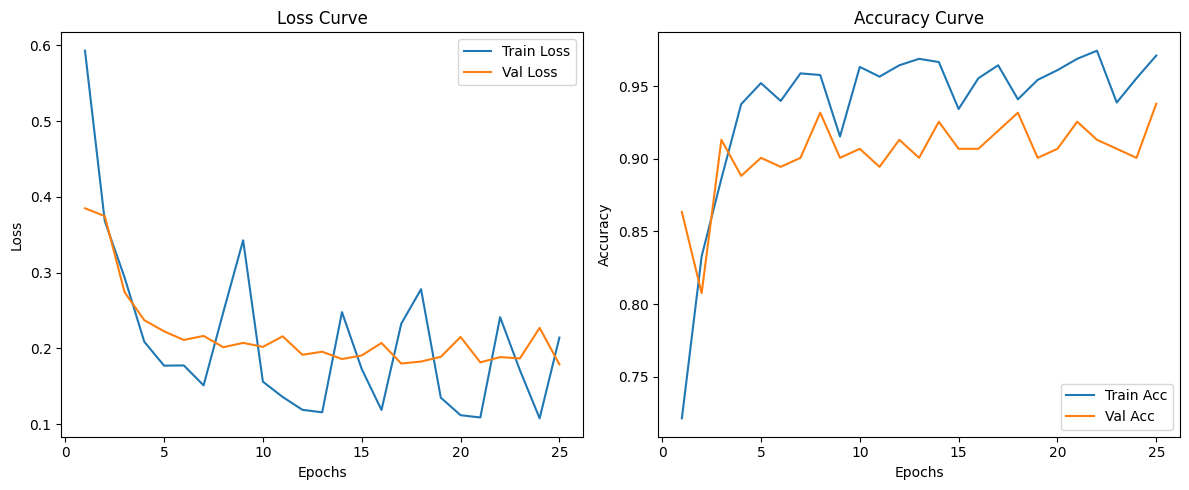

In [20]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report on Test Data:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report on Test Data:
              precision    recall  f1-score   support

     chicken       0.93      0.95      0.94       172
        duck       0.97      0.96      0.97       310

    accuracy                           0.96       482
   macro avg       0.95      0.95      0.95       482
weighted avg       0.96      0.96      0.96       482



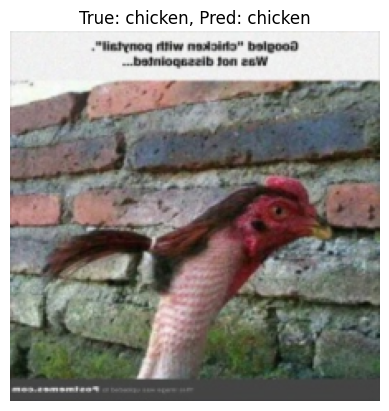

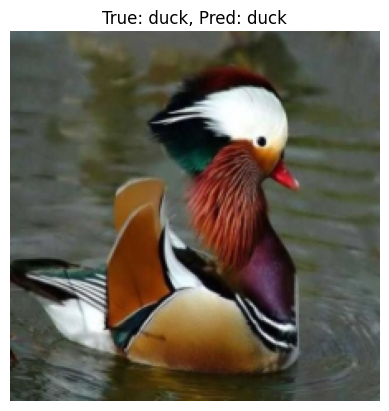

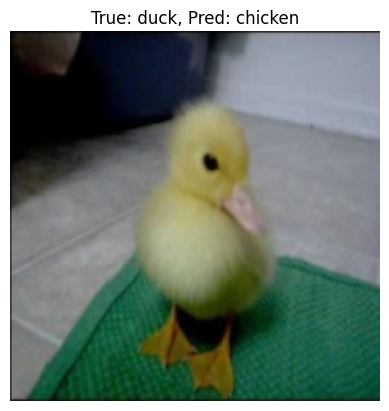

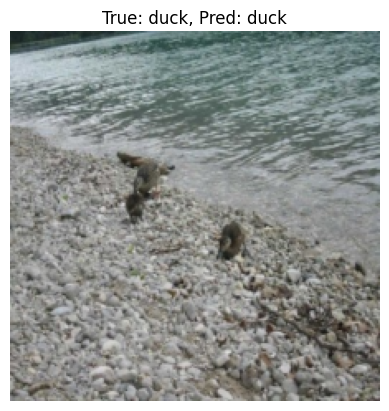

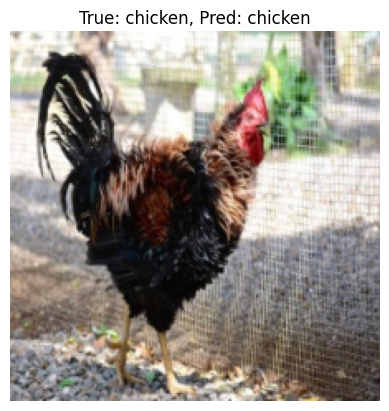

In [ ]:
def imshow(img, label, pred):
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"True: {label}, Pred: {pred}")
    plt.axis('off')
    plt.show()

model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)

outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

for i in range(5):
    imshow(images[i], class_names[labels[i]], class_names[preds[i]])
